## Use CNN as feature extractor and train a simple LogisticRegression

We will use a pretrained CNN model as a feature extractor so we can directly train a LogisticRegression model based on the extracted bottle neck features. It's simple but works surprisingly well!  
We will also try test time augmentation and average, which could also improve our scores on leaderboard!

In [1]:
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader
import torch
import torchvision

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.externals import joblib
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

from src.data import DogBreedDataset, TrainTransform
from src.data import get_test_time_transform, get_train_time_transform_simple
from src.utils import show_data_batch
from src.run import train_model, get_model_bottle_neck
from src.model import initialize_model, get_model_input_size

## data inputs

In [3]:
# set the path and directory for train and validation
train_dataset_csv = 'processed_data/train_train_dataset.csv'

# this is the training set with extra data samples
# extra_train_dataset_csv = 'processed_data/train_train_dataset_more.csv'

val_dataset_csv = 'processed_data/train_valid_dataset.csv'
test_dataset_csv = 'processed_data/test_dataset.csv'

train_root_dir = 'data/train'
test_root_dir = 'data/test'

## training settings

In [4]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model_name = 'inception_v3'
model_name = 'resnet152'
input_size = get_model_input_size(model_name)

# Number of classes in the dataset
num_classes = 120

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for 
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

## load datasets

In [5]:
crop_size = input_size
# we use (scale_size: 256, crop_size: 224) and (scale_size: 320, crop_size: 299)
# for resize and cropping
scale_size = 320 if input_size == 299 else 256

print('input size: {} scale size: {} crop size: {}'.format(input_size, scale_size, crop_size))

input size: 224 scale size: 256 crop size: 224


In [6]:
# transforms settings
train_transform_aug = TrainTransform(scale_size=scale_size, crop_size=crop_size)
train_transform_simple = get_train_time_transform_simple(scale_size=scale_size, crop_size=crop_size)
test_transform = get_test_time_transform(scale_size=crop_size, crop_size=crop_size)

In [7]:
# datasets with transforms
train_dataset_simple = DogBreedDataset(
    csv_file=train_dataset_csv, root_dir=train_root_dir, transform=train_transform_simple)
# train_dataset_aug = DogBreedDataset(
#    csv_file=train_dataset_csv, root_dir=train_root_dir, transform=train_transform_aug)
# train_dataset_simple = DogBreedDataset(
#    csv_file=extra_train_dataset_csv, root_dir=train_root_dir, transform=train_transform_simple)
val_dataset = DogBreedDataset(
    csv_file=val_dataset_csv, root_dir=train_root_dir, transform=test_transform)
test_dataset = DogBreedDataset(
    csv_file=test_dataset_csv, root_dir=test_root_dir, transform=test_transform, train=False)

# use for test time aug
val_dataset_aug = DogBreedDataset(
    csv_file=val_dataset_csv, root_dir=train_root_dir, transform=train_transform_simple)
test_dataset_aug = DogBreedDataset(
    csv_file=test_dataset_csv, root_dir=test_root_dir, transform=train_transform_simple, train=False)

In [8]:
# data loaders
# train_data_loader_aug = DataLoader(
#    train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=4)
train_data_loader_simple = DataLoader(
    train_dataset_simple, batch_size=batch_size, shuffle=True, num_workers=4)
val_data_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_data_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# use for test time aug
val_data_loader_aug = DataLoader(
    val_dataset_aug, batch_size=batch_size, shuffle=False, num_workers=4)
test_data_loader_aug = DataLoader(
    test_dataset_aug, batch_size=batch_size, shuffle=False, num_workers=4)

### test your data loader before training

0 torch.Size([32, 3, 224, 224]) torch.Size([32])


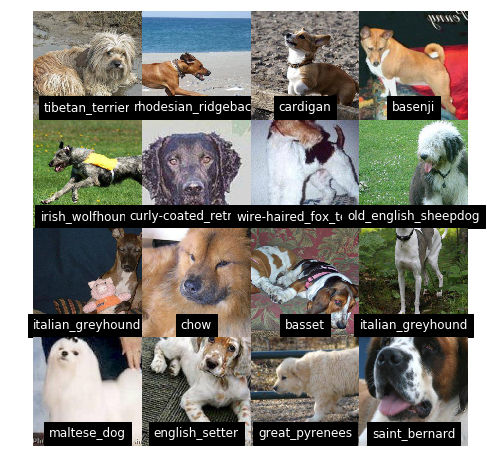

In [11]:
for batch_idx, batch_data in enumerate(train_data_loader_simple):
    print(batch_idx, batch_data['image'].size(), batch_data['label'].size())
    show_data_batch(batch_data, figsize=(8, 8))
    break

### also check your device

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('you are using device: ', device)

you are using device:  cuda:0


## initialize the model

In [13]:
# Initialize the model for this run
model_ft = initialize_model(
    model_name=model_name, num_classes=num_classes, feature_extract=feature_extract, 
    use_pretrained=True, only_bn=True)

model_ft = model_ft.to(device)

## get bottle neck features

In [14]:
# you can use augmentation to generate more training data
train_bn_features = get_model_bottle_neck(
    model=model_ft, device=device, data_loader=train_data_loader_simple, in_notebook=True, 
    train_or_val=True, test_time_aug=False, aug_times=5)

Epoch 0/0
----------




Extracting feature complete in 1m 10s


In [15]:
train_bn_features.head()

,outputs,image_ids,labels
0,"[0.61791235, 0.5779955, 0.14769997, 0.50805885...",d7a98b492b4567df962762fb7ff3cdee,100
1,"[0.76787966, 0.13778742, 0.2154009, 0.44694448...",75f21d23f43b194674f2016f1ce6b153,54
2,"[1.2745821, 0.042180575, 0.6608961, 0.11714464...",ffd3f636f7f379c51ba3648a9ff8254f,35
3,"[0.37917608, 0.44154856, 0.4068539, 0.32294613...",39e60de9434ac684f2b204378ed5126f,94
4,"[0.44944027, 0.53127575, 0.5988385, 0.39322907...",56ddc4e4e63361693d88bdcb0a5cc3ae,93


In [72]:
# you can try test time augmentation on validation set first
val_bn_features = get_model_bottle_neck(
    model=model_ft, device=device, data_loader=val_data_loader_aug, in_notebook=True, 
    train_or_val=True, test_time_aug=True, aug_times=10)

Epoch 0/9
----------


Epoch 1/9
----------


Epoch 2/9
----------


Epoch 3/9
----------


Epoch 4/9
----------


Epoch 5/9
----------


Epoch 6/9
----------


Epoch 7/9
----------


Epoch 8/9
----------


Epoch 9/9
----------



Extracting feature complete in 1m 24s


In [73]:
print(val_bn_features.shape)

(10230, 3)


## train a logistic regression model with the extracted features

In [19]:
def feature_from_dataframe(df, dataset, label=True):
    print('processing extracted features for dataset: ', dataset)
    features = np.zeros((df.shape[0], len(df.iloc[0]['outputs'])))
    raw_features = df['outputs'].values
    for i in range(df.shape[0]):
        features[i] = raw_features[i]
    print('feature shape: ', features.shape)
    
    labels = None
    if label:
        labels = df['labels'].values.astype('int')
        print('label shape: ', labels.shape)
        print('label min: ', np.min(labels), 'label max: ', np.max(labels))
    
    print('-' * 30)
        
    return features, labels

In [20]:
# train_bn_features = pd.read_pickle('results/incep_v3_train_bn_features.pkl')
# val_bn_features = pd.read_pickle('results/incep_v3_val_bn_features.pkl')

In [74]:
train_features, train_labels = feature_from_dataframe(train_bn_features, 'train', label=True)
val_features, val_labels = feature_from_dataframe(val_bn_features, 'val', label=True)

processing extracted features for dataset:  train
feature shape:  (9199, 2048)
label shape:  (9199,)
label min:  0 label max:  119
------------------------------
processing extracted features for dataset:  val
feature shape:  (10230, 2048)
label shape:  (10230,)
label min:  0 label max:  119
------------------------------


In [18]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=26, n_jobs=4)

In [22]:
%%time
logreg.fit(train_features, train_labels)
# we can also try to merge the train and validation together
# train_val_features = np.concatenate([train_features, val_features], axis=0)
# train_val_labels = np.concatenate([train_labels, val_labels], axis=0)
# print(train_val_features.shape)
# print(train_val_labels.shape)

# logreg.fit(train_val_features, train_val_labels)

CPU times: user 337 ms, sys: 178 ms, total: 515 ms
Wall time: 41.1 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=4, penalty='l2', random_state=26, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### check performance on validation set

In [79]:
# if using full dataset, the loss should be very small
# inception v3: 0.28
# resnet152: 0.38
# resnet50: 0.55
# densenet121: 0.62
# interesting!
val_probas = logreg.predict_proba(val_features)
print(log_loss(y_true=val_labels, y_pred=val_probas))

0.44913165247358144


In [76]:
def average_scores_aug(dataset, aug_times, scores):
    # let's average the scores
    scores_avg = scores[:len(dataset)]
    for i in range(1, aug_times):
        scores_avg += scores[i*len(dataset):(i+1)*len(dataset)]
    scores_avg = scores_avg / aug_times

    print('final scores shape: ', scores_avg.shape)
    print('dataset len: ', len(dataset))
    return scores_avg

In [80]:
# if you try test time augmentation, you need to average the final scores
val_probas = average_scores_aug(dataset=val_dataset_aug, aug_times=10, scores=val_probas)
print(log_loss(y_true=val_labels[:len(val_dataset_aug)], y_pred=val_probas))

final scores shape:  (1023, 120)
dataset len:  1023
0.339155709123205


### get test results

In [12]:
#with open('model/incep_v3_bn_features_lr.pkl', 'rb') as fin:
#    logreg = pickle.load(fin)
#logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=4, penalty='l2', random_state=26, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [81]:
test_bn_features = get_model_bottle_neck(
    model=model_ft, device=device, data_loader=test_data_loader_aug, in_notebook=True, 
    train_or_val=False, test_time_aug=True, aug_times=10)

Epoch 0/9
----------


Epoch 1/9
----------


Epoch 2/9
----------


Epoch 3/9
----------


Epoch 4/9
----------


Epoch 5/9
----------


Epoch 6/9
----------


Epoch 7/9
----------


Epoch 8/9
----------


Epoch 9/9
----------



Extracting feature complete in 13m 14s


In [63]:
# test_bn_features = pd.read_pickle('results/incep_v3_test_bn_features.pkl')

In [82]:
test_features, _ = feature_from_dataframe(test_bn_features, 'test', label=False)

processing extracted features for dataset:  test
feature shape:  (103570, 2048)
------------------------------


In [83]:
%%time
test_probas = logreg.predict_proba(test_features)

CPU times: user 6.77 s, sys: 731 ms, total: 7.5 s
Wall time: 1.22 s


In [84]:
# if you try test time augmentation, you need to average the final scores
test_probas = average_scores_aug(dataset=test_dataset_aug, aug_times=10, scores=test_probas)

final scores shape:  (10357, 120)
dataset len:  10357


## save

## process test results

In [85]:
label_mapping = pd.read_csv('processed_data/dog_breed_train_full.csv')
label_mapping = label_mapping[['breed', 'breed_label']].drop_duplicates().sort_values(
    'breed_label', ascending=True)
print(label_mapping.shape)
display(label_mapping.head())

(120, 2)


,breed,breed_label
30,affenpinscher,0
146,afghan_hound,1
15,african_hunting_dog,2
102,airedale,3
125,american_staffordshire_terrier,4


In [86]:
test_submit = pd.DataFrame()
test_submit['id'] = test_bn_features['image_ids'][:len(test_dataset)]
for item in label_mapping.to_dict('record'):
    test_submit[item['breed']] = test_probas[:, int(item['breed_label'])]

In [87]:
test_submit.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,3.198913e-09,1.171756e-10,3.175679e-11,1.138590e-12,4.212617e-14,5.338007e-11,1.864556e-10,2.886919e-11,1.364306e-11,...,4.035509e-10,2.333192e-10,7.561948e-11,4.502152e-10,5.035622e-11,8.908944e-12,2.912361e-11,1.157063e-11,1.555320e-10,6.623948e-09
1,00102ee9d8eb90812350685311fe5890,1.238661e-08,8.894092e-11,5.934243e-09,1.188163e-09,7.124812e-11,2.984379e-06,3.867079e-07,7.488463e-09,7.486040e-11,...,2.206563e-08,6.398914e-08,1.641979e-09,1.906506e-10,2.031143e-09,3.631065e-10,4.042413e-05,7.581049e-10,8.285201e-11,2.309790e-10
2,0012a730dfa437f5f3613fb75efcd4ce,8.363266e-10,3.348256e-04,1.222192e-06,4.821946e-08,3.443481e-08,9.735145e-07,7.676366e-11,9.945009e-11,4.454804e-05,...,5.700677e-10,1.547450e-09,5.374662e-08,1.988127e-06,2.156911e-04,8.613826e-04,1.179982e-09,1.940245e-07,2.620200e-09,9.768178e-07
3,001510bc8570bbeee98c8d80c8a95ec1,2.080547e-03,1.755770e-07,4.033601e-07,1.351552e-07,4.743940e-07,2.579685e-07,1.108739e-09,3.858355e-06,4.450409e-07,...,2.262265e-07,2.446570e-07,1.101698e-06,2.409615e-06,7.608444e-07,2.199402e-07,5.188220e-08,8.712390e-05,1.639380e-09,1.001613e-07
4,001a5f3114548acdefa3d4da05474c2e,1.805483e-02,1.246582e-06,1.973221e-08,2.061972e-10,3.304347e-11,2.387444e-10,3.166934e-09,1.056139e-09,2.640975e-09,...,1.058754e-08,1.842223e-08,1.155445e-09,4.350254e-09,6.468715e-09,2.220954e-08,9.700120e-09,9.517067e-09,1.107327e-08,1.757695e-06


In [88]:
# save the history
test_submit.to_csv('results/resnet152_bn_lr_avg10.csv', index=False)